#  Constitutive Model Fitting

Constitutive models are used by people involved in computational mechancs (and potentially other fields) to simulate the behavior of materials under load. There are many types of models (linear, nonlinear, etc.) which vary in complexity from very simple to extremely complex. These models may be significantly expensive to run though great effort is placed upon solving the equations in an expedient fashion. Most generally, these equations are implemented as ordinary differential equations and solved using Newton-Raphson or some other technique.

It is of interest to fit constitutive equations to data collected in the laboratory and also to have an understanding of how much uncertainty there is in the parameters of the model. Bayesian approaches offer a potential solution for these problems.

## A Prony series viscoelastic model

A viscoelastic material is one in which the modulus of elasticity changes as a function of time. One common modeling approach is to use a collection of spring-damper pairs in parallel (a so-called general Maxwell model)

<img src="./images/maxwell_element.png" width=400>

In the figure $\mathcal{G}$ is a (in the general case) fourth order stiffness tensor, $\eta$ is the damping coefficient, ${E}$ is the applied strain (a second order tensor) and ${\xi}$ is the so-called backstrain in each Maxwell element (also a second order tensor). We can write the stress in one element as

\begin{align*}
\mathbb{G}^i_{IJKL} \left(E_{KL} - \xi^i_{KL}\right) &= \eta_i \dot{\xi}^i_{IJ}\\
\Rightarrow \dot{\xi}_{IJ}^i &= \frac{\mathbb{G}^i_{IJKL}}{\eta_i} \left(E_{KL} - \xi^i_{KL}\right)\\
\end{align*}

If we define $\tau^i = \frac{n_i}{G_{IJKL}}$ Noting that the tensorial nature becomes the identity tensor we can write the evolution equation for ${\xi}^i$ as

\begin{align*}
\dot{\xi}_{IJ}^i &= \frac{E_{KL} - \xi_{KL}^i}{\tau^i}
\end{align*}

We can solve for $\xi$ by using Newton-Raphson iteration (though for linear viscoelascity we can solve for this explicitly using some assumptions). The stress due to this element can be computed therefore via

\begin{align*}
S_{IJ} &= \mathbb{G}^{\infty}_{IJKL} E_{KL} + \sum_{i=1}^n \mathbb{G}_{IJKL}^i \left(E_{KL} - \xi_{KL}^i\right)\\
\end{align*}

Typically, when we use this in the development of a model for a general, 3D material, we break the deformation up into volume preserving (deviatoric) and volume changing (volumetric) stresses. A full stress tensor could be written in index notation (following Holzapfel) as

\begin{align*}
S_{IJ} &= K (1.-J) C_{IJ}^{-1} + 2 J^{-\frac{2}{3}} \left[\mathbb{G}^{\infty}_{IJKL} \hat{E}_{KL} + \sum_{i=1}^n \mathbb{G}_{IJKL}^i \left(\hat{E}_{KL} - \xi_{KL}^i\right)\right]\\
\dot{\xi}_{IJ}^i &= \frac{\hat{E}_{KL} - \xi_{KL}^i}{\tau^i}\\
\hat{E}_{KL} &= E_{KL} - \frac{1}{3} E_{II} \delta_{KL}\\
E_{KL} &= \frac{1}{2} \left(C_{KL} - I_{KL}\right)\\
C_{KL} &= F_{IK} F_{IL}\\
J &= \det\left(F_{MN}\right)
\end{align*}

where $\hat{E}_{KL}$ is the traceless (deviatoric) part of $E$. These equations have been implemented below.

## Discription of problem

We will solve these equations with certain properties at a collection of rates. There will be noise applied to the parameters as well as to the resulting rates and the optimal parameters will be fit to these measures. We will assume that the stiffness tensors are isotropic (i.e. all $\mathbb{G}$s can be represented by scalars) and that the $\tau$ values are known. We define several utility functions for use in our calculations.

In [1]:
#Import required libraries
import numpy as np
import scipy.interpolate
import scipy.optimize as sciopt
import scipy.linalg
import unittest
import os
import matplotlib.pyplot as plt

import pymc3  as pm
import theano as tt

%matplotlib inline

In [2]:
#Define evolution equation of xi
def evolve_xins(dt, e, taus, statevars):
    """Evolve the backstrains"""
    
    for n in range(len(taus)):
        statevars[:,n*3:(n+1)*3] = evolve_xin(e, statevars[:,n*3:(n+1)*3], dt, taus[n])

In [3]:
def decompose_tensor(A):
    """Decompose a tensor into volumetric and deviatoric parts"""
    A_vol = np.trace(A)
    A_dev = A - A_vol*np.eye(3)/3.
    return A_dev,A_vol

def inflate_tensor(Aflat,is_symm=False):
    """Inflate a flattened 3x3 tensor to the matrix form
    
    is_symm: Indicates if the tensor is symmetric and so is stored in 
             6x1 form.
    """
    A = np.zeros([3,3])
    A[0,0] = Aflat[0]
    A[1,1] = Aflat[1]
    A[2,2] = Aflat[2]
    A[1,2] = Aflat[3]
    A[0,2] = Aflat[4]
    A[0,1] = Aflat[5]
    if(is_symm):
        A[2,1] = A[1,2]
        A[2,0] = A[0,2]
        A[1,0] = A[0,1]
    else:
        A[2,1] = Aflat[6]
        A[2,0] = Aflat[7]
        A[1,0] = Aflat[8]
    return A

def deflate_tensor(A,is_symm=False):
    """Deflate a 3x3 tensor to vector form
    
    is_symm: Indicates if the tensor is symmetric and should be stored in 
             6x1 form.
    """
    if(is_symm):
        Aflat = np.zeros([6,])
    else:
        Aflat = np.zeros([9,])
    Aflat[0] = A[0,0]
    Aflat[1] = A[1,1]
    Aflat[2] = A[2,2]
    Aflat[3] = A[1,2]
    Aflat[4] = A[0,2]
    Aflat[5] = A[0,1]
    if(not is_symm):
        Aflat[6] = A[2,1]
        Aflat[7] = A[2,0]
        Aflat[8] = A[1,0]
    return Aflat

In [4]:
def extract_params(params):
    """Extract the parameters"""
    K            = params[0]
    Ginf         = params[1]
    
    num_elements = (len(params)-2)/2
    #num_elements = int(params[2])
    
    taus = np.zeros([num_elements,])
    Gs   = np.zeros([num_elements,])
    
    for i in range(num_elements):
        
        Gs[i]   = params[2+i]
        taus[i] = params[2+i+num_elements]
        
    return K,Ginf,taus,Gs

In [5]:
def evolve_xin(e, xin, dt, taun, maxiter = 20, tol_abs = 1e-9, tol_rel = 1e-9):
    """Use Newton-Raphson to evolve the backstrain"""
    
    dxin   = np.zeros([3,3])
    
    R     = dxin - dt*get_xidot(e,xin,taun)
    
    Rnorm = np.linalg.norm(R)
    
    Rnorm0 = Rnorm
    
    niter = 0
    
    while((np.abs(Rnorm)>tol_abs) and (np.abs(Rnorm/Rnorm0)>tol_rel) and niter<maxiter):
        J = 1. - dt*get_dxidotdxi(e,xin,taun)      #Compute the jacobian
        dxin = dxin - R/J                          #Update dxin
        R = dxin - dt*get_xidot(e,xin+dxin,taun)   #Compute the residual
        Rnorm = np.linalg.norm(R)                  #Update the norm
        niter += 1
        
    if((niter>=maxiter) and (np.abs(Rnorm)>tol_abs) and (np.abs(Rnorm/R0)>tol_rel)):
        print "Error: Convergence not achived in viscoelastic backstrain evolution"
        raise
    return xin+dxin

In [6]:
def get_xidot(en,xi,taun,get_tan=False):
    #Get the rate of change of xi
    
    if(get_tan):
        return (en-xi)/taun,-1./taun
    else:
        return (en-xi)/taun

def get_dxidotdxi(en,xi,taun):
    #Get the jacobian of xidot
    return -1./taun

In [7]:
#def get_cauchy_green_deformation_tensor(F):
#    """Get the Cauchy-Green deformation tensor"""
#    #Compute the Cauchy-Green deformation tensor
#    return np.dot(F.T,F)
#    
#def get_green_lagrange(C):
#    """Compute the Green-Lagrange strain"""
#    
#    #Compute and return the Green-Lagrange strain
#    return 0.5*(C - np.eye(3))
    
def get_stress(dt,F,params,statevars):
    """Compute the stress"""
    
    #Extract the parameters
    K,Ginf,taus,Gs = extract_params(params)
    
    #Set required values related to the deformation gradient
    J   = np.linalg.det(F)
    
    #Compute the Cauchy-Green deformation tensor
    C = np.dot(F.T,F)
    
    #Compute the Green-Lagrange strain
    E = 0.5*(C - np.eye(3))
    
    #Break into deviatoric and volumetric strain
    edev,evol = decompose_tensor(E)
    
    #Evolve the state variables
    evolve_xins(dt,edev,taus,statevars)
    
    #Compute the PK2 stress
    PK2_vol = K*(J-1)*np.linalg.inv(C)#Another option: replace np.linalg.inv(C) with np.eye(3)
    PK2_dev = 2*J**(-2./3)*(Ginf*edev + sum([Gs[n]*(edev-statevars[:,3*n:3*(n+1)]) for n in range(len(taus))]))
    
    PK2     = PK2_vol + PK2_dev
    
    #Map the PK2 stress to the current configuration
    cauchy = (1./J)*np.dot(F,np.dot(PK2,F.T))
    
    return cauchy,E

In [8]:
def form_deformation_gradients(rate):
    """Form the target deformation gradients
    
    The deformation is comprised of a stretch and a rotation 
    (Polar decomposition).
    
    """
    
    times = np.hstack([       0.,   1./rate,  10./rate])
    Us    = [np.eye(3), np.eye(3), np.eye(3)]
    Qs    = [np.eye(3), np.eye(3), np.eye(3)]
    
    Us[1][0,0] = 2.
    Us[2][0,0] = 2.
    
    Fs_noI = np.hstack([np.dot(Q,U)-np.eye(3) for U,Q in zip(Us,Qs)])
        
    return times,Fs_noI

@tt.compile.ops.as_op(itypes=[tt.tensor.dscalar, tt.tensor.dvector, tt.tensor.dvector, tt.tensor.bscalar],otypes=[tt.tensor.dmatrix])
def apply_params_rate(rate,part_params,taus,npts_in):
    """Load up the material at a given rate with the given parameters
    
    to be used in history generation"""
    
    #Reform params
    params = np.hstack([part_params,taus])
    
    #Form the deformation gradient
    #from the right stretch tensor U and 
    #the rotation tensor Q
    tmaxes,Fs_noI = form_deformation_gradients(rate)
    
    I = np.eye(3)
    
    statevars = np.zeros([3,3*len(taus)])
    
    ts     = np.hstack([np.linspace(tlb,tub,npts_in) for tlb,tub in zip(tmaxes[:-1],tmaxes[1:])])
    stress = np.zeros([6,len(ts)])
    strain = np.zeros([6,len(ts)])
    
    tp = 0.
    
    for i,t in enumerate(ts[1:]):
    
        #Set the delta timestep
        dt = t - tp
        
        #Find the upper index of the time
        loc = np.where(tmaxes>=t)[0][0]
        
        #Find the ratio of the time
        ratio = (t-tmaxes[loc-1])/(tmaxes[loc]-tmaxes[loc-1])
        
        #Find the bounding values of the deformation gradient
        Fa = Fs_noI[:,3*(loc-1):3*loc] 
        Fb = Fs_noI[:,3*loc:3*(loc+1)] 
        
        #Compute the deformation gradient
        F = ratio*Fb + (1. - ratio)*Fa + I
        
        #Compute the stress and strain
        cauchy,E      = get_stress(dt,F,params,statevars)
        stress[:,i+1] = deflate_tensor(cauchy,is_symm=True)[:]
        strain[:,i+1] = deflate_tensor(E,is_symm=True)[:]
        
    result = np.vstack([ts,stress,strain])
    return result

@tt.compile.ops.as_op(itypes=[tt.tensor.dscalar, tt.tensor.dvector, tt.tensor.dvector, tt.tensor.bscalar],otypes=[tt.tensor.dvector])
def evaluate_trace(rate,part_params,taus,npts_in):
    """Load up the material at a given rate with the given parameters
    
    to be used in parameter estimation"""
    
    #Reform params
    params = np.hstack([part_params,taus])
    
    #Form the deformation gradient
    #from the right stretch tensor U and 
    #the rotation tensor Q
    tmaxes,Fs_noI = form_deformation_gradients(rate)
    
    I = np.eye(3)
    
    statevars = np.zeros([3,3*len(taus)])
    
    ts     = np.hstack([np.linspace(tlb,tub,npts_in) for tlb,tub in zip(tmaxes[:-1],tmaxes[1:])])
    stress = np.zeros([6,len(ts)])
    strain = np.zeros([6,len(ts)])
    
    tp = 0.
    
    for i,t in enumerate(ts[1:]):
    
        #Set the delta timestep
        dt = t - tp
        
        #Find the upper index of the time
        loc = np.where(tmaxes>=t)[0][0]
        
        #Find the ratio of the time
        ratio = (t-tmaxes[loc-1])/(tmaxes[loc]-tmaxes[loc-1])
        
        #Find the bounding values of the deformation gradient
        Fa = Fs_noI[:,3*(loc-1):3*loc] 
        Fb = Fs_noI[:,3*loc:3*(loc+1)] 
        
        #Compute the deformation gradient
        F = ratio*Fb + (1. - ratio)*Fa + I
        
        #Compute the stress and strain
        cauchy,E      = get_stress(dt,F,params,statevars)
        stress[:,i+1] = deflate_tensor(cauchy,is_symm=True)[:]
        strain[:,i+1] = deflate_tensor(E,is_symm=True)[:]
    print "evaluated"
    print stress[0,:]
    return stress[0,:]
    #result = np.vstack([ts,stress,strain])
    #return result

We can demonstrate a viscoelastic response by using the parameters:

\begin{align*}
K &= 50\\
G_{\infty} &= 50\\
G &= \left[\begin{array}{ccc}
50 & 50 & 50\\
\end{array}\right]\\
\tau &= \left[\begin{array}{ccc}
1E-1 & 1E0 & 1E1\\
\end{array}\right]\\
\end{align*}

And letting the material stretch, without rotation, via
\begin{align*}
T &= \left[\begin{array}{ccc}
1 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0\\
\end{array}\right]\\
t_p &= \frac{1}{r}\\
t_f &= \frac{5}{r}\\
F &= \begin{cases}
T \frac{t}{t_p} + I & \text{for } t\leq t_p\\
T + I & \text{for } t_p<t\leq t_f\\
\end{cases}
\end{align*}

where $r$ is the rate and $I$ is the 3x3 identity tensor. We will run four rates

\begin{align*}
r &= \left[\begin{array}{cccc}
1e-1 & 1e0 & 1e1 & 1e2\\
\end{array}\right]
\end{align*}

and then plot the 11 components of the stress tensor.

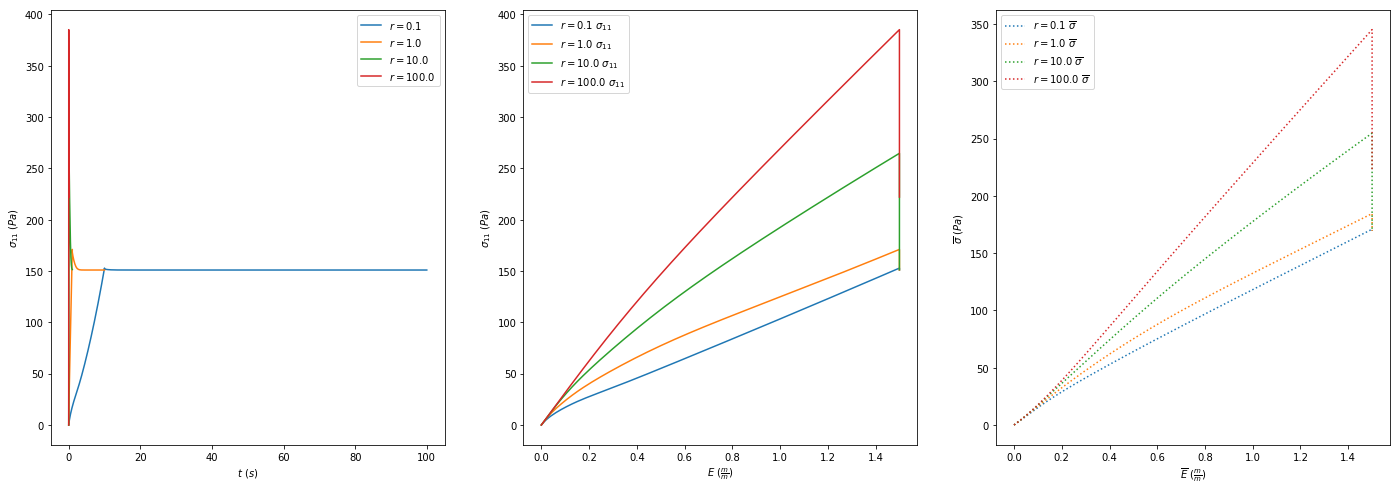

In [9]:
rates  = np.array([1e-1, 1e0, 1e1, 1e2])
part_params = np.hstack([[50.,50.],[50., 50., 50.]])
taus = np.array([1e-1, 1e0, 1e1])
params = np.hstack([part_params,taus])

npts = 100

time_storage   = np.zeros([len(rates),npts*2])
stress_storage = np.zeros([len(rates),6,npts*2])
strain_storage = np.zeros([len(rates),6,npts*2])

plt.figure(figsize=[24,8])
plt.subplot(1,3,1)
plt.xlabel('$t\ (s)$')
plt.ylabel(r"$\sigma_{11}\ (Pa)$")

plt.subplot(1,3,2)
plt.xlabel(r'$E\ (\frac{m}{m})$')
plt.ylabel(r"$\sigma_{11}\ (Pa)$")

plt.subplot(1,3,3)
plt.xlabel(r'$\overline{E}\ (\frac{m}{m})$')
plt.ylabel(r"$\overline{\sigma}\ (Pa)$")

for i,rate in enumerate(rates):
    
    res = apply_params_rate(tt.tensor.as_tensor_variable(rate),tt.tensor.as_tensor_variable(part_params),tt.tensor.as_tensor_variable(taus),tt.tensor.as_tensor_variable(npts))
    
    result = res.eval()
    
    time_storage[i,:]     = result[0,:]
    stress_storage[i,:,:] = result[1:7,:]
    strain_storage[i,:,:] = result[7:,:]
    
    plt.subplot(1,3,1)
    plt.plot(time_storage[i,:],stress_storage[i,0,:],'-',label=r"$r = {0}$".format(rate))
    
    plt.subplot(1,3,2)
    plt.plot(strain_storage[i,0,:],stress_storage[i,0,:],'-',label=r"$r = {0}$".format(rate)+"$\ \sigma_{11}$")
    
    plt.subplot(1,3,3)
    
    plt.plot([sum(strain_storage[i,:3,v]) for v in range(len(time_storage[i]))],\
             [sum(stress_storage[i,:3,v]) for v in range(len(time_storage[i]))],':',label=r"$r = {0}$".format(rate)+"$\ \overline{\sigma}$")

plt.subplot(1,3,1)
plt.legend()
plt.subplot(1,3,2)
plt.legend()
plt.subplot(1,3,3)
plt.legend()
plt.show()

So we can see that different strain rates will result in different stiffnesses of the material. More explicitly, high strain rates are stiffer than low strain rates.

### Simulated Laboratory Tests

These simulations are, effectively, perfect tests of a perfect material. In an actual experiment conducted in a laboratory we will have noise due to
- Material variability (uncertainty in the material parameters)
- Sensor error

If we apply normal noise to the output of 5 Pa, allow the moduli ($K$ $G_{\infty}$ and the $G$s) and the strain rate to vary by due to normally distributed noise with a standard deviation of 5%, and allow the measured strain to vary normally with a mean of zero and a standard deviation of 0.001 and then perform three experiments of each rate. The test will load at a constant rate and then hold the deformation for a length of time equal to ten times the inverse of the rate. This is the same loading path performed before.

In [10]:
#Set the random seed for repetability
np.random.seed(123)

def generate_random_test(test_rate,params,npts_in=100):
    """Generate a test perturbed by random noise"""
    
    #Extract the test parameters
    K,Ginf,taus,Gs = extract_params(params)
    
    #Initialize the test parameters
    #params_test = np.zeros([len(params),])
    params_test = np.zeros([2+len(Gs),])
    
    #Sample the parameters for the test
    params_test[0] = K    + np.random.normal(0.,   K*0.01)
    params_test[1] = Ginf + np.random.normal(0.,Ginf*0.01)
    params_test[2:(2+len(Gs))] = [v + np.random.normal(0.,v*0.01) for v in Gs]
    #params_test[(2+len(Gs)):]  = [v for v in taus]
    
    res = apply_params_rate(tt.tensor.as_tensor_variable(test_rate),\
                            tt.tensor.as_tensor_variable(params_test),\
                            tt.tensor.as_tensor_variable(taus),\
                            tt.tensor.as_tensor_variable(npts_in))
    result = res.eval()
    
    ts       = result[0,:]
    stresses = result[1:7,:]
    strains  = result[7:,:]
    
    stresses = np.array([[v + np.random.normal(0.,5.)    for v in stresses[w]] for w in range(6)])
    strains  = np.array([[v + np.random.normal(0.,0.001) for v in  strains[w]] for w in range(6)])
    
    return ts,stresses,strains

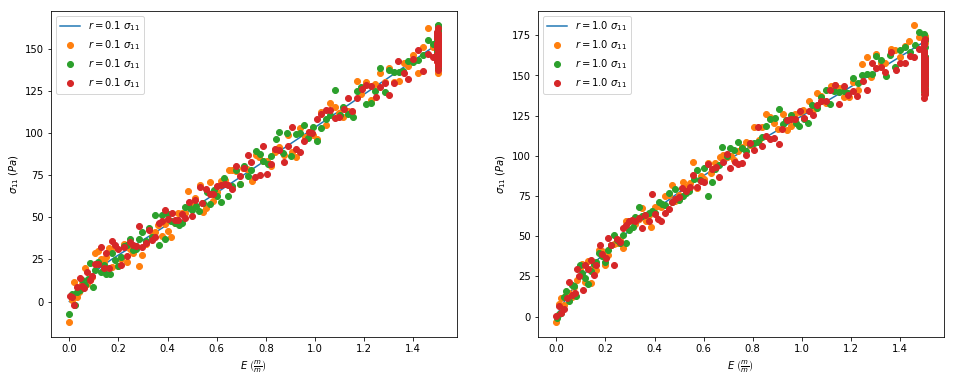

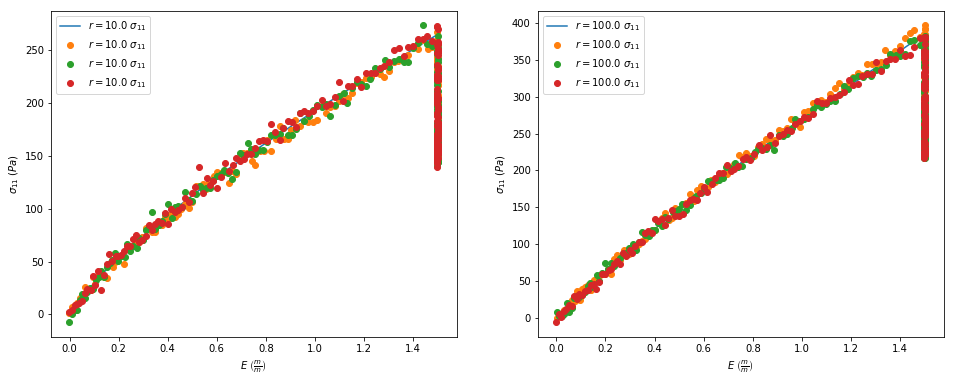

In [11]:
#Sample from the random tests

number_of_replicants = 3

test_time_storage   = np.zeros([len(rates),3,  2*npts])
test_stress_storage = np.zeros([len(rates),3,6,2*npts])
test_strain_storage = np.zeros([len(rates),3,6,2*npts])

nominal_rates = np.zeros([len(rates)*number_of_replicants])

nrows = len(rates)/2
row = 1
tmp = 1

for i,rate in enumerate(rates):

    plt.figure(row,figsize=[16,6])
    plt.subplot(1,2,tmp)
    tmp += 1
    if(tmp>2):
        tmp = 1
        row += 1
    
    plt.plot(strain_storage[i,0,:],stress_storage[i,0,:],'-',label=r"$r = {0}$".format(rate)+"$\ \sigma_{11}$")
    
    for replicant in range(number_of_replicants):
        nominal_rates[i*replicant] = rate
        test_rate = rate + np.random.normal(0.,0.05*rate)
        test_time_storage[i,replicant,:], test_stress_storage[i,replicant,:,:], test_strain_storage[i,replicant,:,:] =\
            generate_random_test(test_rate,params,npts_in=npts)
        plt.plot(test_strain_storage[i,replicant,0,:],test_stress_storage[i,replicant,0,:],'o',label=r"$r = {0}$".format(rate)+"$\ \sigma_{11}$")
    plt.xlabel(r"$E\ \left(\frac{m}{m}\right)$")
    plt.ylabel(r"$\sigma_{11}\ (Pa)$")
    plt.legend()
plt.show()

### Estimating parameters

In order to estimate the parameters for a given experiment, we must define an error metric. For now, we can use a squared error normalized by the variance.

Often times, for actual experiments, we may only have the history of some measures (stress and strain are both computed from load-displacement data). In this case, we will assume that we have $\sigma_{11}$ and $E_{11}$ derived from the load-displacement data for each test. This will make it impossible to distinguish between the volumetric and deviatoric contributions of $K$ and $G_{\infty}$.

The organization of each dataset is:

data[rate, replicant, measure]

where each rate index corresponds to the values in the list: rates

The total data set is the applied conditions:

<table style="width:50%">
  <tr>
    <th>Name</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>test_time_storage</td>
    <td>Time measure</td>
  </tr>
  <tr>
    <td>E11s</td>
    <td>Strain in the 11 direction</td>
  </tr>
</table> 

and the measured response:
<table style="width:50%">
  <tr>
    <th>Name</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>s11s</td>
    <td>Stress in the 11 direction</td>
  </tr>
</table> 

In [ ]:
s11s          = np.vstack([[     test_stress_storage[r,rep,0,:]  for rep in range(number_of_replicants)] for r in range(len(rates))])
E11s          = np.vstack([[     test_strain_storage[r,rep,0,:]  for rep in range(number_of_replicants)] for r in range(len(rates))])

We will use the nominal loading rates and deformations for our optimization. This is reasonable since we are (typically) controlling the deformations and measuring the resultant loads. We will define a function to compile our simulated responses to the parameters we will be optimizing into a matrix 

In [ ]:
data = tt.shared(s11s[0])
rate = tt.shared(nominal_rates[0])

number_maxwell_elements = 3

t_params = tt.shared(np.zeros([2+2*number_maxwell_elements]))

tausm  = tt.tensor.as_tensor_variable(np.array([1e-1,1e0,1e1]))

with pm.Model() as model:
    #Parameter defintions
    t_params = pm.Uniform("t_params", lower=0., upper=100., shape=(5,))
    Km    = pm.Deterministic("Km", t_params[0])
    Ginfm = pm.Deterministic("Ginfm", t_params[1])
    Gsm   = pm.Deterministic("Gsm", t_params[2:])
    sigma = pm.HalfNormal('sigma', sd=1)
    
    tt.tensor.printing.Print('t_params')(t_params)
    tt.tensor.printing.Print("Km")(Km)
    tt.tensor.printing.Print("Ginfm")(Ginfm)
    tt.tensor.printing.Print("Gsm")(Gsm)
    tt.tensor.printing.Print("sigma")(sigma)
    
    #Evaluate the response
    response = evaluate_trace(rate,t_params,tausm,tt.tensor.as_tensor_variable(npts))
    tt.tensor.printing.Print("response")(response)
    
    measured_stress   = pm.Normal( "measured_stress", mu=response, sd = sigma, observed=data)#data)
    
    tt.tensor.printing.Print("measured_streses")(measured_stress)
    tt.tensor.printing.Print("data")(data)
    
    #step = pm.Slice()
    traces = pm.sample(1,tune=1,n_init=1,njobs=1)
    

t_params __str__ = [ 50.  50.  50.  50.  50.]
Km __str__ = 50.0
Ginfm __str__ = 50.0
Gsm __str__ = [ 50.  50.  50.]
sigma __str__ = 0.797884560803
evaluated
[   0.            3.21553072    6.46429331    9.74509345   13.05669912
   16.39784711   19.76724954   23.16360039   26.58558197   30.03187134
   33.50114661   36.99209314   40.50340949   44.03381325   47.58204661
   51.14688162   54.72712524   58.32162405   61.92926861   65.54899751
   69.179801     72.82072434   76.47087063   80.12940337   83.79554856
   87.46859638   91.14790253   94.83288913   98.52304524  102.21792701
  105.91715745  109.62042585  113.32748686  117.03815923  120.7523243
  124.46992413  128.1909594   131.91548712  135.64361804  139.37551394
  143.1113847   146.85148524  150.59611238  154.34560158  158.10032358
  161.86068105  165.62710516  169.40005222  173.18000028  176.96744576
  180.76290022  184.56688711  188.3799387   192.202593    196.03539094
  199.87887357  203.73357944  207.60004214  211.47878799  215.3

  148.60744526  162.60148241  155.03945657  151.56643566  150.5646604 ]
data __str__ = [ -12.13339622    0.65781568   11.44652927    2.8098252     5.58606567
   10.19640324   19.70429447   10.54956688   12.96198605   14.40065415
   28.94987697   30.16061731   25.51288484   23.65069722   26.5981131
   31.52517795   20.52660544   32.19890909   21.14988371   25.32117203
   34.13237385   23.5412298    31.07689454   28.56917768   32.71132033
   21.12072391   27.39453476   33.90664125   43.21308263   38.89354708
   40.97816486   45.62336625   39.01871403   46.08413048   41.90379295
   38.57150029   46.5487192    52.67934031   52.82367296   52.40495109
   65.7719372    57.23302065   61.43257782   69.11192377   52.84477595
   55.52678743   70.8562165    59.5755633    65.15372354   71.80245822
   72.37106893   78.16467429   78.35218981   77.71565877   70.01086824
   79.36542827   78.49016754   71.82617043   87.09369317   85.60410725
   83.36714779   83.55707865   80.32496864   88.91915119   91.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Assigned Slice to t_params_interval__
Assigned NUTS to sigma_log__
  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

evaluated
[   0.            3.21553072    6.46429331    9.74509345   13.05669912
   16.39784711   19.76724954   23.16360039   26.58558197   30.03187134
   33.50114661   36.99209314   40.50340949   44.03381325   47.58204661
   51.14688162   54.72712524   58.32162405   61.92926861   65.54899751
   69.179801     72.82072434   76.47087063   80.12940337   83.79554856
   87.46859638   91.14790253   94.83288913   98.52304524  102.21792701
  105.91715745  109.62042585  113.32748686  117.03815923  120.7523243
  124.46992413  128.1909594   131.91548712  135.64361804  139.37551394
  143.1113847   146.85148524  150.59611238  154.34560158  158.10032358
  161.86068105  165.62710516  169.40005222  173.18000028  176.96744576
  180.76290022  184.56688711  188.3799387   192.202593    196.03539094
  199.87887357  203.73357944  207.60004214  211.47878799  215.37033387
  219.27518524  223.19383433  227.12675846  231.0744186   235.03725803
  239.01570119  243.01015274  247.02099671  251.04859582  255.093291

  208.37878457  207.61202897  206.85038534  206.0936366   205.34158434]
evaluated
[   0.            2.78341692    5.60862242    8.47417051   11.37858727
   14.32037691   17.29802782   20.31001869   23.35482458   26.430923
   29.53679982   32.67095513   35.83190894   39.01820664   42.2284243
   45.46117371   48.71510714   51.98892179   55.28136398   58.59123291
   61.91738418   65.25873282   68.61425606   71.98299565   75.36405976
   78.75662459   82.15993547   85.57330768   88.9961268    92.42784871
   95.86799929   99.31617367  102.77203523  106.23531421  109.70580608
  113.18336962  116.6679247   120.15944989  123.65797977  127.16360218
  130.67645517  134.19672392  137.72463746  141.26046536  144.80451432
  148.35712477  151.91866734  155.48953945  159.07016188  162.66097532
  166.26243709  169.87501788  173.49919853  177.13546705  180.78431562
  184.44623782  188.12172598  191.81126864  195.51534821  199.23443877
  202.96900407  206.71949567  210.48635122  214.26999301  218.0708265

  200.60395108  199.83719548  199.07555185  198.31880312  197.56675085]
evaluated
[   0.            2.71914363    5.48134858    8.28513142   11.12898227
   14.01137072   16.93075189   19.88557244   22.87427663   25.89531226
   28.94713662   32.02822224   35.13706258   38.27217739   41.43211807
   44.61547254   47.82087008   51.04698567   54.29254416   57.55632403
   60.83716084   64.13395027   67.44565082   70.77128611   74.10994681
   77.46079216   80.82305107   84.19602293   87.57907792   90.97165702
   94.37327165   97.78350295  101.2020007   104.62848199  108.06272953
  111.5045897   114.95397034  118.41083836  121.87521702  125.34718315
  128.82686414  132.31443476  135.81011397  139.31416155  142.82687468
  146.3485845   149.87965267  153.42046783  156.97144225  160.53300833
  164.10561533  167.68972607  171.28581376  174.89435896  178.51584661
  182.15076323  185.79959427  189.46282156  193.14092099  196.83436027
  200.54359696  204.26907654  208.01123079  211.77047623  215.5472

  200.14045956  199.37370396  198.61206033  197.8553116   197.10325934]
evaluated
[   0.            2.71571121    5.47455172    8.27503609   11.1156525
   13.99486872   16.91113809   19.86290556   22.84861372   25.86670881
   28.91564658   31.9938981    35.09995539   38.23233687   41.38959258
   44.57030919   47.77311475   50.99668304   54.23973778   57.50105634
   60.7794732    64.07388301   67.38324328   70.70657665   74.04297287
   77.39159025   80.75165685   84.12247119   87.50340263   90.89389137
   94.29344805   97.70165306  101.11815546  104.54267163  107.97498359
  111.41493708  114.86243929  118.31745649  121.78001136  125.25018013
  128.72808961  132.21391404  135.70787183  139.21022223  142.72126192
  146.24132155  149.77076227  153.3099723   156.85936341  160.41936758
  163.99043363  167.57302397  171.16761141  174.77467608  178.39470256
  182.02817699  185.67558445  189.33740641  193.01411841  196.70618783
  200.41407188  204.13821574  207.87905085  211.63699344  215.41244

  200.1171568   199.3504012   198.58875757  197.83200884  197.07995657]
evaluated
[   0.            2.7155397     5.4742121     8.27453165   11.11498645
   13.99404417   16.91015804   19.86177296   22.84733142   25.86527957
   28.91407311   31.99218302   35.09810125   38.23034615   41.3874677
   44.56805251   47.77072855   50.99416956   54.23709919   57.49829477
   60.77659071   64.07088163   67.38012495   70.70334331   74.03962637
   77.38813243   80.74808948   84.11879602   87.49962136   90.89000565
   94.2894595    97.69756325  101.11396595  104.53838393  107.97059918
  111.41045739  114.85786574  118.31279047  121.7752542   125.24533317
  128.72315413  132.20889131  135.70276308  139.20502868  142.71598475
  146.23596192  149.76532133  153.30445115  156.85376315  160.41368927
  163.98467833  167.5671927   171.16170517  174.76869587  178.38864934
  182.02205171  185.66938803  189.33113977  193.00778245  196.69978342
  200.40759988  204.131677    207.8724462   211.63032369  215.40570

  200.11599606  199.34924045  198.58759683  197.83084809  197.07879583]
evaluated
[   0.            2.71553116    5.47419519    8.27450653   11.11495328
   13.99400311   16.91010924   19.86171656   22.84726756   25.8652084
   28.91399476   31.99209761   35.09800892   38.23024702   41.38736189
   44.56794014   47.77060973   50.9940444    54.2369678    57.49815725
   60.77644718   64.07073217   67.37996967   70.7031823    74.03945973
   77.38796024   80.74791184   84.11861301   87.49943306   90.88981215
   94.28926088   97.6973596   101.11375733  104.53817042  107.97038085
  111.41023432  114.857638    118.31255812  121.77501732  125.24509181
  128.72290837  132.2086412   135.70250869  139.20477006  142.71572197
  146.23569503  149.76505039  153.30417622  156.85348427  160.41340652
  163.98439174  167.56690233  171.16141106  174.76839808  178.38834791
  182.02174669  185.66907948  189.33082772  193.00746694  196.6994645
  200.4072776   204.13135139  207.87211731  211.62999156  215.405373

  200.11593827  199.34918266  198.58753903  197.8307903   197.07873804]
evaluated
[   0.            2.71553074    5.47419435    8.27450528   11.11495163
   13.99400106   16.91010681   19.86171375   22.84726438   25.86520486
   28.91399086   31.99209336   35.09800432   38.23024208   41.38735662
   44.56793454   47.77060381   50.99403817   54.23696126   57.49815041
   60.77644003   64.07072473   67.37996194   70.70317428   74.03945143
   77.38795167   80.747903     84.1186039    87.49942369   90.88980252
   94.28925099   97.69734946  101.11374694  104.53815979  107.97036998
  111.41022321  114.85762666  118.31254655  121.77500552  125.24507979
  128.72289613  132.20862875  135.70249602  139.20475719  142.71570889
  146.23568175  149.7650369   153.30416253  156.85347039  160.41339244
  163.98437747  167.56688787  171.16139642  174.76838325  178.38833291
  182.02173151  185.66906411  189.33081218  193.00745123  196.69944863
  200.40726156  204.13133518  207.87210094  211.62997502  215.4053

  200.11593539  199.34917978  198.58753616  197.83078742  197.07873516]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400096   16.91010669   19.86171361   22.84726423   25.86520468
   28.91399066   31.99209315   35.0980041    38.23024184   41.38735636
   44.56793426   47.77060351   50.99403786   54.23696094   57.49815007
   60.77643968   64.07072436   67.37996156   70.70317388   74.03945102
   77.38795124   80.74790256   84.11860344   87.49942322   90.88980204
   94.2892505    97.69734895  101.11374643  104.53815926  107.97036944
  111.41022266  114.85762609  118.31254597  121.77500494  125.24507919
  128.72289552  132.20862813  135.70249539  139.20475655  142.71570823
  146.23568108  149.76503623  153.30416185  156.8534697   160.41339174
  163.98437676  167.56688715  171.16139569  174.76838252  178.38833216
  182.02173075  185.66906335  189.33081141  193.00745045  196.69944784
  200.40726076  204.13133437  207.87210012  211.6299742   215.4053

  200.11593525  199.34917964  198.58753601  197.83078728  197.07873502]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520468
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790254   84.11860342   87.4994232    90.88980201
   94.28925048   97.69734893  101.1137464   104.53815923  107.97036942
  111.41022263  114.85762607  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688712  171.16139566  174.76838248  178.38833212
  182.02173072  185.66906331  189.33081137  193.00745041  196.6994478
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535619


  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

  200.11593524  199.34917963  198.58753601  197.83078727  197.07873501]
evaluated
[   0.            2.71553072    5.4741943     8.27450522   11.11495155
   13.99400095   16.91010669   19.8617136    22.84726422   25.86520467
   28.91399065   31.99209314   35.09800408   38.23024183   41.38735634
   44.56793425   47.7706035    50.99403784   54.23696092   57.49815005
   60.77643966   64.07072434   67.37996154   70.70317386   74.039451
   77.38795122   80.74790253   84.11860342   87.4994232    90.88980201
   94.28925047   97.69734893  101.1137464   104.53815923  107.97036941
  111.41022263  114.85762606  118.31254594  121.77500491  125.24507916
  128.72289549  132.20862809  135.70249536  139.20475651  142.7157082
  146.23568105  149.7650362   153.30416181  156.85346966  160.4133917
  163.98437673  167.56688711  171.16139565  174.76838248  178.38833212
  182.02173071  185.66906331  189.33081137  193.00745041  196.69944779
  200.40726072  204.13133433  207.87210008  211.62997416  215.40535618

In [ ]:
#number_of_samples = 500
#
#traces = []
#data_number = 1
#for data_vals,test_rate in zip(s11s,nominal_rates):
#    # Switch out the observed dataset
#    print "Sampling data record {0}".format(data_number)
#    data.set_value(data_vals)
#    rate.set_value(test_rate)
#    with model:
#        
#        # obtain starting values via MAP
#        #start = pm.find_MAP(fmin=sciopt.fmin_powell)
#
#        # instantiate sampler
#        step = pm.Slice()
#        
#        traces.append(pm.sample(number_of_samples,step=step,model=model,njobs=1))
#    data_number += 1
#
#pm.traceplot(traces[0])